# Model Building

The purpose of this notebook is to build some models that will determine whether a player is over or under paid. Because Machine Learning techniques can't do us any good in our attempt to establish value (i.e. what a player *ought* to be paid), we will use them to predict team wins or a player's individual 'winshare'. 

### Imports

In [11]:
# import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [12]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## Data

In [13]:
df = pd.read_csv('data/processed/players_final.csv')

df = df[(df.salary.notnull())&(df['Last Name'].notnull())&(df['Dist.'].notnull())]


In [14]:
df.shape

(6193, 75)

# 1 Winshare (WS) Contribution

Summary of Winshare Contribution model here.

In [15]:
from lib.modeling import ws_assessment

ws_assessment(year = 2018).head()

Salary cap for 2018:	 101869000


,Full Name,Tm,W,L,salary,burden,cluster,WS,exp_WS,overpaid
1674,Stephen Curry,GSW,57,25,37457154.0,0.306,Combo Guard,9.7,13.5,True
8,Russell Westbrook,OKC,49,33,35665000.0,0.292,Floor General,6.8,12.8,True
1002,LeBron James,LAL,37,45,35654150.0,0.292,Combo Guard,7.2,12.8,True
530,Chris Paul,HOU,53,29,35654150.0,0.292,Floor General,6.6,12.8,True
679,Kyle Lowry,TOR,58,24,32700000.0,0.268,Combo Guard,6.6,11.8,True


# 2 Cluster-specific Feature Percentiles

Summary of Percentile assessment here.

In [16]:
from lib.modeling import cluster_compare
df.columns

Index(['Full Name', 'Pos', 'cluster', 'index', 'Last Name', 'First Name', 'Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'salary', 'Dist.', '2P_A', '0-3_A', '3-10_A', '10-16_A', '16-3pt_A', '3P_A',
       '0-3%', '3-10%', '10-16%', '16-3pt%', 'Astd_2P', 'Dunk%', 'Dunks_Md', 'Astd_3P', '%Corner3_A', 'Corner_3P%', 'Heaves_A', 'Heaves_Md'],
      dtype='object')

C:\Users\gcox3\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


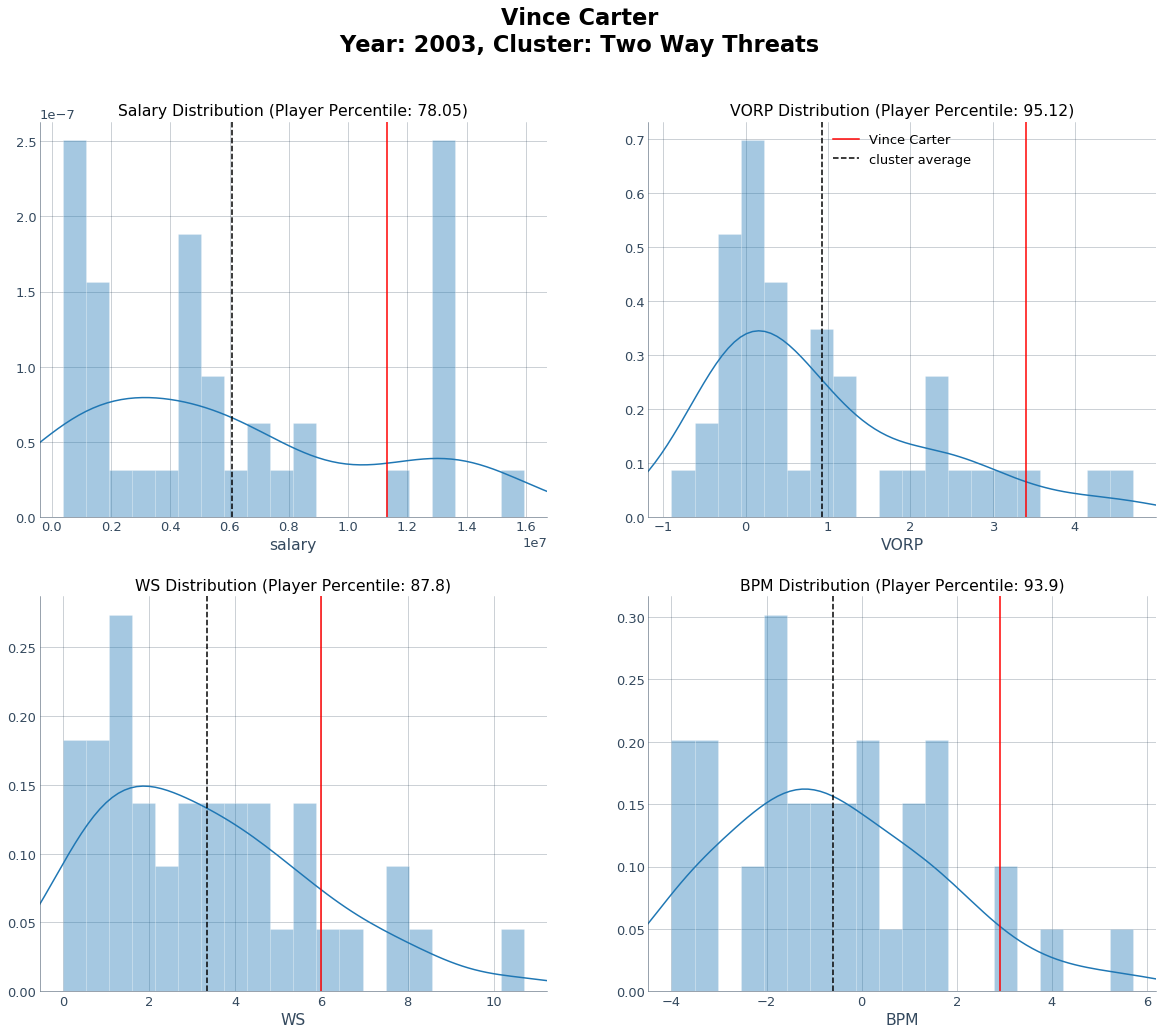

In [17]:
cluster_compare(player = 'Vince Carter', year = 2003)

# 4 Regression Analysis

In [19]:
grouped_df = df.groupby('Full Name').mean()

In [20]:
grouped_df.salary.describe()

count    7.020000e+02
mean     5.195810e+06
std      3.741892e+06
min      6.177500e+04
25%      2.300000e+06
50%      4.243415e+06
75%      7.236883e+06
max      1.973349e+07
Name: salary, dtype: float64

In [35]:
rich = df[df.salary >= 0.4*max(df.salary)]
len(rich)

498

In [126]:
df.corr().sort_values('salary', ascending = False).loc[:,'salary'][:14]
cor_target = abs(df.corr()['salary'])
high_cors = cor_target[cor_target > 0.3]
list(high_cors.index)

['GS',
 'FG',
 'FGA',
 'FT',
 'PTS',
 'PER',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'OBPM',
 'BPM',
 'VORP',
 'salary']

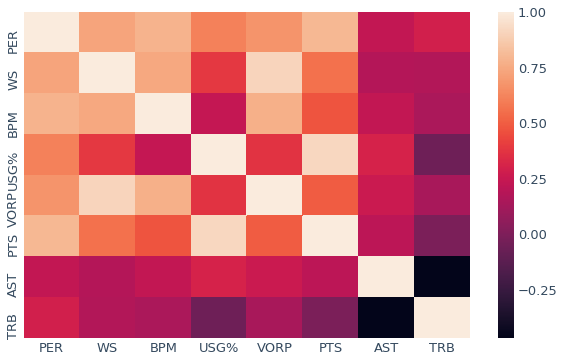

In [89]:
sns.heatmap(df[['PER','WS','BPM','USG%','VORP','PTS','AST','TRB']].corr())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     165.2
Date:                Wed, 11 Sep 2019   Prob (F-statistic):          3.54e-130
Time:                        16:04:58   Log-Likelihood:                -11309.
No. Observations:                 702   AIC:                         2.263e+04
Df Residuals:                     695   BIC:                         2.266e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.446e+08   4.98e+07     -2.903      0.0

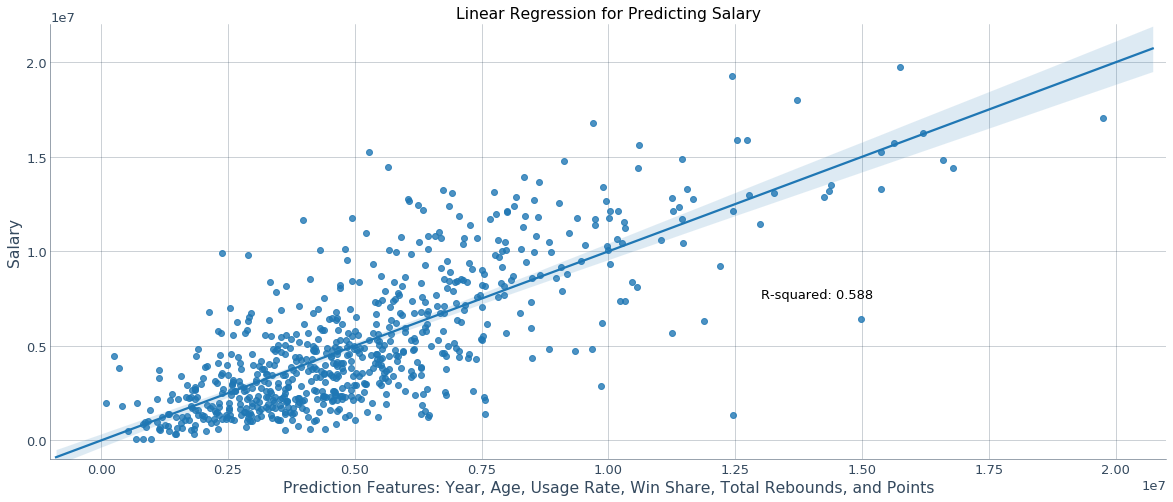

In [214]:
data = grouped_df

data.rename(columns = {'USG%':'USG', 
                       '3P':'Threes',
                       '3PAr':'ThreeAttemptRate'} , inplace = True)

m_1 = ols('salary ~ Age + PTS + TRB + AST + VORP + WS + USG + PER + BPM + Threes + ThreeAttemptRate', data).fit()

# second model uses offensive statistics only
m_2 = ols('salary ~ Age + PTS + AST + ORB + OWS + OBPM + ORtg + TOV + USG + Threes', data).fit()

# third model uses defensive staistics only
m_3 = ols('salary ~ Age + DRB + DWS + DBPM + DRtg + STL + BLK', data).fit()

# final model attempting to reduce input features and to remove negative coefficients
m_4 = ols('salary ~ Year + Age + USG + WS + TRB + PTS', data = data).fit()

model = m_4

print(model.summary())

plt.figure(figsize = (20,8))
sns.regplot(x = model.fittedvalues, y = 'salary', data = data, fit_reg = True)
plt.ylabel('Salary')
plt.xlabel('Prediction Features: Year, Age, Usage Rate, Win Share, Total Rebounds, and Points')
plt.title('Linear Regression for Predicting Salary')
plt.text(1.3e7, 7.5e6, 'R-squared: {}'.format(round(model.rsquared,3)))
plt.ylim([-0.1e7, 2.2e7])
plt.xlim([-0.1e7, 2.1e7])
plt.savefig('assets/linreg.png')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     652.6
Date:                Wed, 11 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:12:27   Log-Likelihood:            -1.0346e+05
No. Observations:                6193   AIC:                         2.069e+05
Df Residuals:                    6186   BIC:                         2.070e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.081e+08    2.1e+07    -24.207      0.0

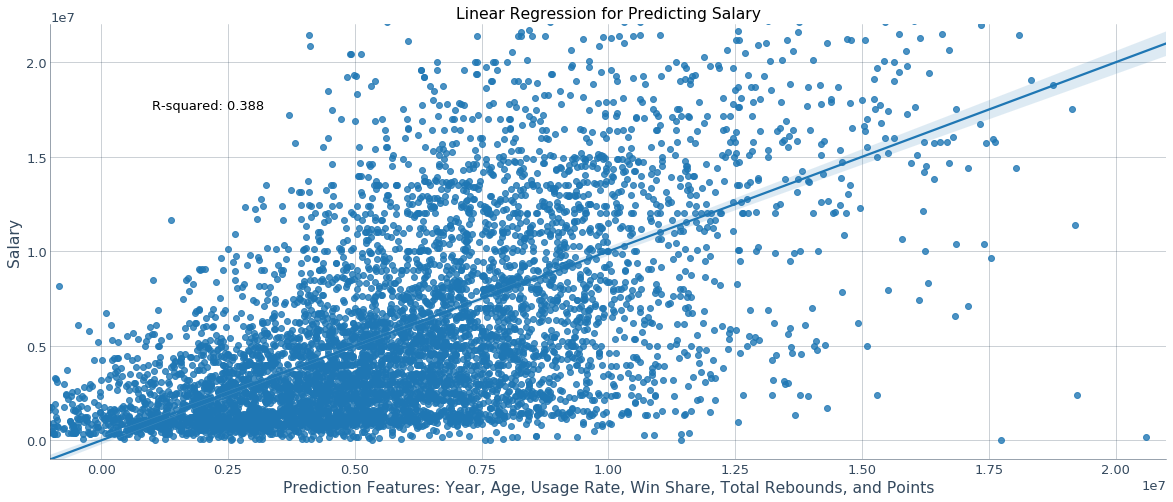

In [217]:
data = df

data.rename(columns = {'USG%':'USG', 
                       '3P':'Threes',
                       '3PAr':'ThreeAttemptRate'} , inplace = True)

m_1 = ols('salary ~ Age + PTS + TRB + AST + VORP + WS + USG + PER + BPM + Threes + ThreeAttemptRate', data).fit()

# second model uses offensive statistics only
m_2 = ols('salary ~ Age + PTS + AST + ORB + OWS + OBPM + ORtg + TOV + USG + Threes', data).fit()

# third model uses defensive staistics only
m_3 = ols('salary ~ Age + DRB + DWS + DBPM + DRtg + STL + BLK', data).fit()

# final model attempting to reduce input features and to remove negative coefficients
m_4 = ols('salary ~ Year + Age + USG + WS + TRB + PTS', data = data).fit()

model = m_4

print(model.summary())

plt.figure(figsize = (20,8))
sns.regplot(x = model.fittedvalues, y = 'salary', data = data, fit_reg = True)
plt.ylabel('Salary')
plt.xlabel('Prediction Features: Year, Age, Usage Rate, Win Share, Total Rebounds, and Points')
plt.title('Linear Regression for Predicting Salary')
plt.text(0.1e7, 1.75e7, 'R-squared: {}'.format(round(model.rsquared,3)))
plt.ylim([-0.1e7, 2.2e7])
plt.xlim([-0.1e7, 2.1e7])
plt.savefig('assets/linregfulldata.png')

plt.show()

In [188]:
# using Scikit-Learn and all features, we get an Rsquared of only .475
# compared to the Scipy models that top out at 0.566 Rsquared

from sklearn import linear_model
from sklearn.model_selection import train_test_split

data = df.fillna(0)

y = data.salary
X = data.drop(['Full Name', 'First Name', 'Last Name', 'cluster', 'Pos', 'Tm'], axis = 1)
X = X.drop('salary',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 23)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

m_1.rsquared, m_2.rsquared, m_3.rsquared, m_4.rsquared, regr.score(X, y)

(0.5945097596347197,
 0.5332493659772912,
 0.4844865174926656,
 0.5828469626634449,
 0.4754650840073572)